# **Diagonalisation of Hermitian Matrices**

#### Matthew Smith

## **Imports**

In [3]:
import numpy
import numpy.random as random
import matplotlib.pyplot as pyplot
import time
from numpy import transpose, cos, sin, log, sqrt
import sys

## **Introduction**

Matrix diagonalisation is a very important problem in many areas of physics. Diagonalsing a matrix $A$ consists of finding a diagonal matrix $D$ and matrix $M$ such that,

$$D = M^* A M \text{ .}$$

**Diagonal Matrix**: A matrix whose elements are all zero, apart from those on the primary diagonal.

When solved, the elements $\lambda_j = D_{jj}$ are in-fact the eigenvalues of $A$, and collumns $\vec{v}_j = (M_{ij})_i$ are the corresponing eigenvectors. These quantities are such that,

$$A\vec{v}_j = \lambda_j \vec{v}_j \text{ .}$$

Since many differential equations may be stated in this form (after fixing a basis), the process of diagonalisation can prove very useful. For example, the Time-Independent Schrodinger Equation may be stated as. 

$$\hat{H}\psi = E\psi \text{ ,}$$

where $\hat{H} = -\dfrac{\hbar^2}{2m}\nabla^2 + V$ is the Hamiltonian operator. 

For this notebook, we cocentrate on a subset of matrices:

**Dense Matrix**: Matrix with mostly non-zero elements.

Note however, that we only cover the diagonalisation of real symmetric matrices, and Hermitian matrices.

**Real Symmetric Matrix**: A matrix whose elements are equal to their counterpart opposite the diagonal. $A_{ij} = A_{ji}$. This is to say that the matrix is equal to its transpose $A^T$. 

**Hermitian Matrix**: A matrix whose elements are equal to the complex conjugate of their conterpart opposite the primary diagonal. $H_{ij} = H^{*}_{ji}$. This is to say the matrix is equal to its **Hermitian Conjugate**.

## **Constructing the Method**

The compuational diagonalisation of a dense real symmetric matrix $A$ follows two main steps (Thijssen, page 595):

1. Transfrom $A$ into a tridiagonal matrix $B$ by successive left-transpose and right multiplications by a sequence of matrices $O_i$.
2. Transfrom $B$ into an upper-triangular matrix $U$ by the **QR Algorithm**.

An alternative for step 2 is suggested by Sastry. 

**Tridiagonal Matrix**: A matrix whose elements are all necessarily zero, apart from those on the primary diagonal, or horizontally or vertically neighbouring a primary diagonal element. 

The eigenvalues are on the diagonal of $U$. This method is known as the **Householder Method**. 

#### **Step 1: Symmetric to Tridiagonal**

In order to transform a Hermitian matrix into a tridiagonal one, we make use of **Householder Reflections**. The version of the method used here, comes from Thijssen A8.2. 

Let $A$ be an $n \times n$ real symmetric matrix. To transform into a tridiagonal matrix $B$:

1. Set $i = n$ and $B = A$.
2. Set $c$ to the $i^\text{th}$ column of $B$. Set $X_j = 0$ for $i \leq j \leq n$.
3. Set $u = c - |c|e_{i - 1}$, where $e_k$ is the $k^\text{th}$ standard basis vector.
4. Set $P = I - 2uu^T$. 
5. Set $B = PBP$.
6. Set $i = i - 1$. 
7. If $i > 2$, then go back to 2. 
8. Final result is $B$. 

Now we shall write a function to do this.

In [4]:
def I(n):
    M = numpy.zeros((n, n), dtype = float)
    for i in range(n):
        M[i, i] = 1.0
    return M

def basis(n, k):
    E = numpy.zeros((n, 1), dtype = float)
    E[k, 0] = 1.0
    return E

def norm(M):
    N = numpy.copy(M)
    y = (transpose(N)@N)[0, 0]
    y = y**0.5
    return y

def isTri(A):
    res = True
    n = len(A)
    for j in range(2, n):
        if(A[0, j] != 0.0): return False
    for j in range(n - 2):
        if(A[n - 1, j] != 0.0): return False
    for i in range(1, n - 1):
        for j in range(i - 1):
            if(A[i, j] != 0.0): return False
        for j in range(i + 2, n):
            if(A[i, j] != 0.0): return False
    return True

def sym2tri(A):
    B = numpy.copy(A)
    n = len(A)
    M = I(n)
    for i in range(n, 2, -1):
        if(isTri(B)): return B, M
        C = numpy.zeros((n, 1), dtype = float)
        C[0:(i - 1), 0] = B[0:(i - 1), i - 1]
        U = C - norm(C)*basis(n, i - 2)
        P = I(n) - 2.0*(U@transpose(U))/(norm(U)**2.0)
        B = P@(B@P)
        M = M@P
    return B, M

In [5]:
#test the above code
A = numpy.zeros((4, 4), dtype = float)
for i in range(4):
    for j in range(i + 1):
        if(i == j): A[i, j] = 0.1*random.randint(-10, 10)
        else:
            A[i, j] = 0.1*random.randint(-10, 10) 
            A[j, i] = A[i, j]

numpy.set_printoptions(precision=3)

print("Original Matrix: {}".format(A))
B, P = sym2tri(A)
print("Tridiagonal: {}".format(B))

Original Matrix: [[-0.4  0.1  0.8 -0.6]
 [ 0.1  0.9  0.5  0.3]
 [ 0.8  0.5  0.3  0.7]
 [-0.6  0.3  0.7  0.4]]
Tridiagonal: [[ 4.103e-01  1.282e-01 -3.691e-16 -1.648e-16]
 [ 1.282e-01  8.302e-01  9.422e-01 -2.543e-17]
 [-4.524e-16  9.422e-01 -4.404e-01  9.695e-01]
 [-1.648e-16 -2.543e-17  9.695e-01  4.000e-01]]


Our algorithm is seen to work.

#### **Step 2: Tridiagonal to Upper-Triangular**

This step requires an understanding of **QR factorisation**, which is discussed in *QR Decomposition* (see References). To give the QR factoristion of a matrix $A$, is to find unitary matrix $Q$ and upper-triangular matrix $R$ such that,

$$A = QR \text{ .}$$

**Unitary Matrix**: A matrix whose Hermitian conjugate is also the inverse. 

To find these matrices, we first apply the Gramm-Schmidt procedure to find an orthogonal set of unit vectors $e_i$, given the initial set of vectors from the matrix columns.

Let $A = \begin{pmatrix} a_1 | a_2 | a_3 | \cdots | a_n \end{pmatrix}$. Then $e_i$ are found as follows.

1. Set $i = 1$.
2. Set $u_i = a_1 - \sum_{k = 2}^i (a_k \cdot e_k)e_k$.
3. Set $e_i = \dfrac{u_i}{|u_i|}$.
4. Set $i = i + 1$.
5. If $i \leq N$, then fo back to 2. 

Once we have $e_i$ note that,

$$A =
\begin{pmatrix}
e_1 | e_2 | e_3 | \cdots | e_n
\end{pmatrix}
\begin{pmatrix}
a_1 \cdot e_1 & a_2 \cdot e_1 & \cdots & a_n \cdot e_1 \\
0 & a_2 \cdot e_2 & \cdots & a_n \cdot e_2 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & a_n \cdot e_n
\end{pmatrix}
$$

This is the QR factorisation of $A$. 

$Q = \begin{pmatrix}
e_1 | e_2 | e_3 | \cdots | e_n
\end{pmatrix}$$

AND 

$$R = \begin{pmatrix}
a_1 \cdot e_1 & a_2 \cdot e_1 & \cdots & a_n \cdot e_1 \\
0 & a_2 \cdot e_2 & \cdots & a_n \cdot e_2 \\
\vdots & \vdots & \ddots & \vdots\\
0 & 0 & \cdots & a_n \cdot e_n
\end{pmatrix}$$

With this method of factorisation, we set up the iteration scheme, $A_k = R_{k - 1} Q_{k - 1}$.

$A_k$ converges to an upper-triangular matrix $B$. The diagonal elements of this matrix are the eigenvalues of $A$.

Now we shall write the code for this. 

In [6]:
def gramm_schmidt(A):
    E = numpy.copy(A)
    n = len(A)
    for k in range(n):
        Ek = E[:, k]
        for i in range(0, k):
            Ek = Ek - numpy.dot(A[:, k], E[:, i])*E[:, i]
        Ek = numpy.dot(Ek, Ek)**(-0.5)*Ek
        E[:, k] = Ek
    return E

def QR(A):
    Q = gramm_schmidt(A)
    n = len(A)
    R = numpy.zeros((n, n), dtype = float)
    for i in range(n):
        for j in range(i, n):
            R[i, j] = numpy.dot(A[:, j], Q[:, i])
    return Q, R

In [7]:
def dense_sym_diagonalise_QR(A, N):
    n = len(A)
    B = numpy.copy(A)
    
    B, M = sym2tri(B)
    
    for i in range(N):
        Q, R = QR(B)
        B = R@Q
        M = M@Q
    D = numpy.copy(B)
    for i in range(n):
        for j in range(n):
            if(not i == j): D[i, j] = 0.0
                
    return D, M

#### **Step 2 (Alternative): Characteristic Equation of the Tridiagonal Matix**

A method of obtaining the eigenvalues of a tridiagonal matrix $B$, is given by Sastry. The method is based on the characteristic polynomial of the matrix, $\phi(t) = \det(B - t I)$. The roots of charcteristic equation $\phi(t) = 0$ are the eigenvalues $\lambda$ of $B$. To compute the characterisitc equation, we employ the recurrence given by Sastry 7.7.1.
$$\phi_0(t) := 1$$
$$\phi_1(t) := a_{1,1} - t$$
$$\phi_k(t) := (a_{k,k} - t)\phi_{k - 1}(t) - a_{k - 1, k}^2 \phi_{k - 2}(t)$$
Sastry claims that $\phi_k$ defines a Sturm sequence. These are pivotal in Sturm's Theorem, described in *Finding All the Roots: Sturm's Theorem* (see References). The theorem states that the number of roots on an interval $(a, b)$, of a function $\phi_n$ in a Sturm sequence is,
$$|\sigma(b) - \sigma(a)| \text{ ,}$$
where $\sigma(c)$ is the number of sign changes in the sequence $\phi_k(c)$ ($0 \leq k \leq n$). This provides us with a means of isolating the roots of $\phi_n$, as now we may divide our initial interval until the difference above is one. So given we wish to find all eigenvalues in $(a, b)$, execute the following:

1. Evaluate $\phi_k(a)$ and $\phi_k(b)$ for all $0 \leq k \leq n$. 
2. Compute $\sigma(b)$, $\sigma(a)$, and hence $N = \sigma(a) - \sigma(b)$. 
3. If N = 0, terminate. Otherwise, continue.
4. If N = 1, then perform interval bisection to find single eigenvalue and return to any parent process. Otherwise, continue. 
5. If N > 1, then set $c = \dfrac{a + b}{2}$. Now perform this algorithm for both intervals $(a, c)$ and $(c, b)$. Record the result from both of these.
6. We now have a complete set of eigenvalues on $(a, b)$.

I shall now write the code to do this. 

In [31]:
def phi(A, k, t):
    y = 0.0
    if(k == 0): y = 1.0
    elif(k == 1): y = A[0, 0] - t
    else:
        y = (A[k - 1, k - 1] - t)*phi(A, k - 1, t) - A[k - 2, k - 1]**2.0*phi(A, k - 2, t)
    return y

def diff(a, b):
    if(a >= 0 and b <= 0): return True
    elif(a <= 0 and b >= 0): return True
    else: return False
    
def sigma(A, c):
    n = len(A)
    s = 0
    p = phi(A, 0, c)
    for i in range(n):
        q = phi(A, i + 1, c)
        if(diff(p, q)): s = s + 1
        p = q
    return s

def bisect_solve(A, a, b, M):
    n = len(A)
    p = phi(A, n, a)
    q = phi(A, n, b)
    for i in range(M):
        c = 0.5*(a + b)
        r = phi(A, n, c)
        if(diff(p, r)): 
            b = c
            q = r
        else: 
            a = c
            p = r
    x = 0.5*(a + b)
    return x

def sturm_solve(A, a, b, M):
    n = len(A)
    p = sigma(A, a)
    q = sigma(A, b)
    N = abs(p - q)
    sol = []
    if(N == 0):
        return sol
    elif(N == 1):
        x = bisect_solve(A, a, b, M)
        sol.append(x)
    else:
        c = 0.5*(a + b)
        X = sturm_solve(A, a, c, M)
        Y = sturm_solve(A, c, b, M)
        sol = sol + X + Y
    return sol

def dense_sym_eigen_char(A, a, b, M):
    B, P = sym2tri(A)
    lam = sturm_solve(B, a, b, M)
    lam = numpy.array(lam)
    return lam

As a test, compute the eigenvalues of $\begin{pmatrix} 1 & 7 \\ 7 & 3 \end{pmatrix}$. Analytically, these are found to be $2 \pm 5\sqrt{2}$.

First with the QR approach.

In [16]:
A = numpy.array([[1.0, 7.0], [7.0, 3.0]], dtype = float)
D, M = dense_sym_diagonalise_QR(A, 1000)

print("A = {}".format(A))
print("D = {}".format(D))
print("M = {}".format(M))

print("M*AM = {}".format(transpose(M)@A@M)) #note: using 'tranpose' because example matrix is real

#check M contains eigenvector
print("Av - lam v = {}".format(A@M[:, 0] - D[0, 0]*M[:, 0]))

A = [[1. 7.]
 [7. 3.]]
D = [[ 9.071  0.   ]
 [ 0.    -5.071]]
M = [[ 0.655 -0.755]
 [ 0.755  0.655]]
M*AM = [[ 9.071e+00 -5.882e-15]
 [-5.423e-15 -5.071e+00]]
Av - lam v = [ 3.553e-15 -4.441e-15]


Then with the characteristic equation approach. 

In [26]:
A = numpy.array([[1.0, 7.0], [7.0, 3.0]], dtype = float)


lam = dense_sym_eigen_char(A, -100.0, 100.0, 1000)

print(lam)

[-5.071  9.071]


The test of the Householder with QR Method was successful, as the final difference shows that the obtained results were indeed the eigenpairs. The second method is perfectly consistent with the first, although it has the disadvantage of not giving eigenvectors. This is because I have not yet learned how to account for degeneracy. 

**Degenerate Eigenvalue**: An eigenvalue with more than one eigenvector associated with it. 

#### **Adapting the Method for Hermitian Matices**

The methods developed above were built for real symmetric matrices. We often desire however, to diagonalise complex Hermitian matrices. Thijssen claims that the Householder method has an analogous form for these, however experimenting with the code, this generalisation eludes me. I shall instead attempt something a little more cunning. 

Consider a Hermitian matrix $H$. By considering the real and imaginary parts of each element, we may decompose $H$ using two real matrices, 

$$H = A + iB \text{ .}$$

Note that $A$ is symmetric and $B$ is anti-symmetric. 

**Anti-symmetric Matrix**: A matrix whose elements are equal to the negative of their counterpart opposite the diagonal. $A_{ij} = -A_{ji}$. This is to say that the matrix is equal to the negative transpose. 

Now suppose we wish to solve the eigenvalue problem,

$$H\vec{v} = \lambda \vec{v} \text{ .}$$

After writing $\vec{v} = \vec{a} + i\vec{b}$, we may restate the problem as,

$$(A + iB)(\vec{a} + i\vec{b}) = \lambda ( \vec{a} + i \vec{b} ) \text{ .}$$

Expanding this we get,

$$A \vec{a} + iA \vec{b} + iB \vec{a} - B\vec{b} = \lambda (\vec{a} + i \vec{b}) \text{ .}$$

Now we collect the real and imaginary parts. Note that since $H$ is Hermitian, $\lambda \in \mathbb{R}$. 

$$A \vec{a} - B \vec{b} = \lambda \vec{a}$$

$$B \vec{a} + A \vec{b} = \lambda \vec{b}$$

This may be expressed as a new eigenvalue problem,

$$\begin{pmatrix} A & -B \\ B & A \end{pmatrix} \begin{pmatrix} \vec{a} \\ \vec{b} \end{pmatrix} = \lambda \begin{pmatrix} \vec{a} \\ \vec{b} \end{pmatrix} \text{ .}$$

The matrix on the left is a real symmetric matrix. This means that we can now apply our method from above. Note that because the dimension has doubled, we will need to be crafty with the list of eigenvalues. 

In [33]:
def herm(A):
    B = numpy.copy(A)
    B = transpose(B).conj()
    return B

def dense_herm_diagonalise_QR(H, N):
    n = len(H)
    A = numpy.real(H)
    B = numpy.imag(H)
    C = numpy.zeros((2*n, 2*n), dtype = float)
    C[0:n, 0:n] = A[:, :]
    C[0:n, n:] = -B[:, :]
    C[n:, 0:n] = B[:, :]
    C[n:, n:] = A[:, :]
    
    Dc, Mc = dense_sym_diagonalise_QR(C, N)

    D = numpy.zeros((n, n), dtype = complex)
    M = numpy.zeros((n, n), dtype = complex)

    TRACKER = numpy.copy(Dc) # matrix to aid selection of eigenvalues
    for j in range(n):
        pri = []
        for i in range(2*n): pri.append(abs(TRACKER[i, i]))
        k = pri.index(max(pri))
        D[j, j] = Dc[k, k]
        for i in range(n): M[i, j] = Mc[i, k] + 1.0j*Mc[n + i, k]
        TRACKER = TRACKER - Dc[k, k]*I(2*n)

    return D, M

In [12]:
H = numpy.array([[3.0, 1.0 + 1.0j], [1.0 - 1.0j, -5.0]], dtype = complex)
D, M = dense_herm_diagonalise_QR(H, 1000)


print("H = {}".format(H))
print("D = {}".format(D))
print("M = {}".format(M))

print("M*HM = {}".format(herm(M)@H@M)) 

#check M contains eigenvector
print("Hv - lam v = {}".format(H@M[:, 0] - D[0, 0]*M[:, 0]))


H = [[ 3.+0.j  1.+1.j]
 [ 1.-1.j -5.+0.j]]
D = [[-5.243+0.j  0.   +0.j]
 [ 0.   +0.j  3.243+0.j]]
M = [[ 0.12 +1.196e-01j -0.697-6.969e-01j]
 [-0.986-8.942e-16j -0.169+8.857e-15j]]
M*HM = [[-5.243e+00-2.776e-17j -6.106e-16+4.380e-14j]
 [-6.661e-16-4.374e-14j  3.243e+00+2.220e-16j]]
Hv - lam v = [ 3.331e-15-2.887e-15j -3.553e-15-7.721e-16j]


The method for diagonalising a Hermitian matrix clearly works here.

## **Convergence**

Since our method involved an iteration scheme, it makes sense to study the convergence. To do this, we look at how the square difference between the returned eigenvalue vector and the true eigenvalue vector evolves with step number. 

In [31]:
n = 5
A = numpy.zeros((n, n), dtype = complex)
for i in range(n):
    for j in range(i + 1):
        A[i, j] = random.randint(-10, 10) + random.randint(-10, 10)*1.0j
        A[i, j] = 0.1*A[i, j]
        A[j, i] = numpy.conj(A[i, j])
print("A = ")
print(A)

N = 100
dN = 10

D, P = dense_herm_diagonalise_QR(A, 100*N)

lam = numpy.zeros((n), dtype = float)

for i in range(n): lam[i] = numpy.real(D[i, i])

lam_true = max(abs(lam))

LAM = numpy.zeros((int(N/dN)), dtype = float)

for i in range(0, N, dN):
    D, P = dense_herm_diagonalise_QR(A, i)
    for j in range(n): lam[j] = numpy.real(D[j, j])
    lam_i = max(abs(lam))
    LAM[int(i/dN)] = lam_i

A = 
[[ 0.9+0.3j -0.8+0.6j -0.3-0.2j -0.3+0.6j  0.8-0.7j]
 [-0.8-0.6j -0.8+0.8j  0.8-0.8j -0.5+0.6j -0.1-0.6j]
 [-0.3+0.2j  0.8+0.8j -0.7-0.3j  0.2+0.4j  0.3-0.2j]
 [-0.3-0.6j -0.5-0.6j  0.2-0.4j -0.7-0.5j -0.3+0.6j]
 [ 0.8+0.7j -0.1+0.6j  0.3+0.2j -0.3-0.6j  0.9+1.j ]]


In [32]:
ERR = LAM - lam_true
Ns = numpy.arange(0, N, step = dN, dtype = int)
m, c = numpy.polyfit(Ns, log(abs(ERR)), 1)

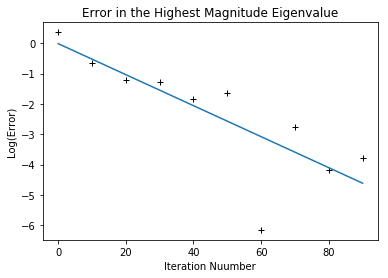

Gradient: -0.05104611752547952


In [33]:
pyplot.plot(Ns, log(abs(ERR)), linestyle = "None", marker = "+", ms = 6, color = "k")
pyplot.plot(Ns, m*Ns + c)
pyplot.xlabel("Iteration Nuumber")
pyplot.ylabel("Log(Error)")
pyplot.title("Error in the Highest Magnitude Eigenvalue")
pyplot.show()

print("Gradient: {}".format(m))

We see that we have exponential convergence. The decay constant appears very dependent on the particular elements in $A$. 

## **Execution Time**

We now study the dependence of diagonalisation execution time on the dimension $n$ of the matrix $A$.

In [34]:
def get_mean_time(n, N, M):
    A = numpy.zeros((n, n), dtype = complex)
    for i in range(n):
        for j in range(i + 1):
            A[i, j] = random.randint(-10, 10) + random.randint(-10, 10)*1.0j
            A[i, j] = 0.1*A[i, j]
            A[j, i] = A[i, j].conj()
    t1 = time.time()
    for i in range(N): dense_herm_diagonalise_QR(A, M)
    t2 = time.time()
    t_avg = (t2 - t1)/N
    return t_avg

In [35]:
def get_grad(ns, T, i, j):
    m, c = numpy.polyfit(log(ns), log(T), 1)
    return m

In [37]:
ns = numpy.arange(10, 400, 20, dtype = int)
T = numpy.zeros((len(ns)), dtype = float)
for i in range(len(ns)):
    print(ns[i])
    T[i] = get_mean_time(ns[i], 1, 1)

10
30
50
70
90
110
130
150
170
190
210
230
250
270
290
310
330
350
370
390


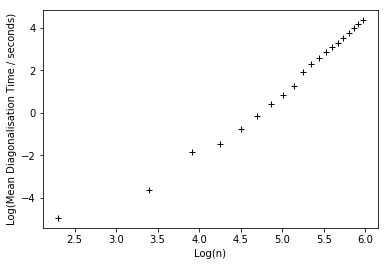

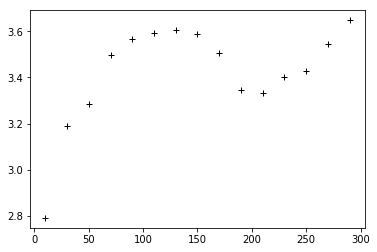

In [38]:
pyplot.figure()
pyplot.plot(log(ns), log(T), linestyle = "None", marker = "+", ms = 6, color = "k")
pyplot.xlabel("Log(n)")
pyplot.ylabel("Log(Mean Diagonalisation Time / seconds)")
pyplot.show()

Ms = []
for i in range(len(ns) - 5):
    m, c = numpy.polyfit(log(ns)[i:38], log(T)[i:38], 1)
    Ms.append(m)
    
    
pyplot.figure()
pyplot.plot(ns[:len(ns) - 5], Ms, linestyle = "None", marker = "+", ms = 6, color = "k")
pyplot.show()

The data is consistent with the claim by Thijssen, that the execution time grows with $n^3$. 

## **Evaluation**

In writing this notebook, I have learned:
1. The Householder Method for diagonalising a real symmetric matrix.
2. QR Factorisation of a tridiagonal matrix.
3. Sturm's Theorem for isolating roots. 
4. A way of expressing a Hermitian eigenvalue problem as a real symmetric eigenvalue problem.
4. The convergence rate of the Householder method.
5. The time-scaling of the Householder method.

I intend to use these methods soon for a notebook on [Variational Quantum Mechanics](VariationalQM.ipynb), I subject which after reading about, I was inspired to write this notebook.  

## **References**

**Books**:

*Computational Physics* by Thijssen; Second Edition (2007); Cambridge University Press; ISBN-978-1-107-67713-5

*Introductory Methods of Numerical Analysis* by Sastry; Fifth Edition (2012); PHI Learning; ISBN-978-81-203-4592-8

**Web**:

*QR Decomposition with Gramm-Schmidt*; PDF found at: https://www.math.ucla.edu/~yanovsky/Teaching/Math151B/handouts/GramSchmidt.pdf; accessed 9th Jan 2019. Copy of PDF [here](QR.pdf).

*Finding All the Roots: Sturm's Theorem*; PDF found at http://web.math.ucsb.edu/~padraic/mathcamp_2013/root_find_alg/Mathcamp_2013_Root-Finding_Algorithms_Day_2.pdf; accessed 19th Jan 2019. Copy of PDF [here](Sturm.pdf).
